# Assignment 2: Tokenization, Word Embeddings, and Vector Algebra

## Introduction
In this assignment, we will explore the problem of getting from sequences of characters to wordtypes with different meanings. You will implement widely-used algorithms for tokenizing text and computing context-less word embeddings, and perform analysis on the results of running these algorithms.

Learning objectives:
* Understand how byte pair encoding works as a method for tokenizing character sequences, and how it differs from simpler tokenization methods like splitting on whitespace.
* Gain insights on how to compute and interpret language statistics, including Zipf's laws of word frequencies.
* Understand basics of distributional semantics, including basic implementations of word embedding algorithms.
* Learn to use vector algebra as a way of analyzing a space of word embeddings.

**Notes:**
* In your solution, keep all code as-is except where it's explicitly mentioned to implement a function.
* Items marked with a star (★) should be answered in a separate report as a text document with the corresponding item number. You will include your final report as a pdf with your submission.

**Submission:**

You will submit a single zip file `submission.zip` to Gradescope containing the following:

```
hw2.ipynb # your completed jupyter notebook
report.pdf # your written report
results/ # outputs from jupyter notebook
├── solve_analogy.json
├── W_en_fr.npy
├── W_en_ja.npy
└── ... (and all other generated files)
```

# Setup

Run the following cell to set up the helper function for saving your results. This function will create a directory called `results` and save the output of each of your implemented functions as a `.json` file inside.

In [ ]:
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [3]:
import sys
import torch

print("Python executable:", sys.executable)
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


Python executable: c:\Users\cjmc7\anaconda3\envs\ugrad-nlp\python.exe
PyTorch version: 2.8.0+cpu
CUDA available: False
CUDA version: None
Device: CPU


In [3]:
import json
import os
from collections import Counter, defaultdict
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tokenizers import ByteLevelBPETokenizer
from tokenizers.normalizers import Lowercase

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

def save_results(results, filename):
    if not os.path.exists('results'):
        os.makedirs('results')
    with open(os.path.join('results', filename), "w") as f:
        json.dump(results, f, indent=4)

# Load the corpus
with open('data/stories.txt', 'r', encoding='utf-8') as f:
    en_corpus = [line.strip() for line in f.readlines()]

print(f"Loaded {len(en_corpus)} sentences.")
print("First 5 sentences:", en_corpus[:5])

Loaded 10000 sentences.
First 5 sentences: ['The Happy Prince.', 'HIGH above the city, on a tall column, stood the statue of the Happy Prince.  He was gilded all over with thin leaves of fine gold, for eyes he had two bright sapphires, and a large red ruby glowed on his sword-hilt.', 'He was very much admired indeed.  “He is as beautiful as a weathercock,” remarked one of the Town Councillors who wished to gain a reputation for having artistic tastes; “only not quite so useful,” he added, fearing lest people should think him unpractical, which he really was not.', '“Why can’t you be like the Happy Prince?” asked a sensible mother of her little boy who was crying for the moon.  “The Happy Prince never dreams of crying for anything.”', '“I am glad there is some one in the world who is quite happy,” muttered a disappointed man as he gazed at the wonderful statue.']


## Part 1: Tokenization (25 points)

In this part, you will implement two standard methods for tokenization to convert a sequence of characters into a sequence of tokens.

### Part 1.0: Setup
**Implement:** A helper function that, given a sequence of tokenized sentences, returns a dictionary pairing word types with their counts.

In [3]:
def count_word_types(tokenized_sentences: List[List[str]]) -> Dict[str, int]:
    """
    Given a list of tokenized sentences, return a dictionary mapping each word type to its frequency.
    """

    word_counter = Counter()
    
    for sentence in tokenized_sentences:
        word_counter.update(sentence)
    
    return dict(word_counter)

word_counts_output = count_word_types(en_corpus)
print(word_counts_output)

{'T': 8842, 'h': 176648, 'e': 291861, ' ': 558753, 'H': 3449, 'a': 182766, 'p': 28687, 'y': 41450, 'P': 2146, 'r': 119415, 'i': 133220, 'n': 150590, 'c': 43350, '.': 22326, 'I': 9262, 'G': 1369, 'b': 31010, 'o': 166640, 'v': 18578, 't': 208957, ',': 50165, 'l': 90522, 'u': 58910, 'm': 50228, 's': 126879, 'd': 113277, 'f': 43484, 'w': 62458, 'g': 47489, '-': 3388, '“': 11059, 'k': 19735, '”': 10867, 'C': 1263, ';': 4190, 'q': 1525, 'W': 3359, '’': 3134, '?': 2626, 'z': 830, 'j': 2152, 'M': 1597, 'A': 3772, '!': 3166, 'O': 1458, 'S': 3023, 'E': 776, 'x': 1845, 'R': 824, 'Y': 885, 'B': 2309, '—': 97, 'F': 1316, 'Q': 377, 'N': 1231, 'K': 1918, 'L': 1095, 'J': 414, 'D': 1047, 'U': 149, ':': 1065, 'V': 117, '[': 9, ']': 10, '‘': 211, "'": 741, '*': 91, '1': 229, '4': 52, '8': 47, '2': 60, '5': 48, '3': 54, 'Z': 12, '9': 44, '0': 45, '/': 1, '(': 133, ')': 133, 'X': 2, '7': 47, '6': 47, '&': 1, '"': 1500, 'ö': 8, 'ä': 6}


### Part 1.1: Simple tokenization (10 points)
**Implement:** A function that splits a given input string by whitespace into sequences of tokens.

In [4]:
def simple_tokenize(text: str) -> List[str]:
    """
    Splits a given input string by whitespace into a sequence of tokens.
    """
    
    return text.split()

In [8]:
freq_dic = count_word_types([simple_tokenize(sentence) for sentence in en_corpus])
print(sorted(freq_dic.items(), key=lambda x: x[1], reverse=True))

[('the', 34392), ('and', 24581), ('to', 15159), ('a', 10956), ('he', 9618), ('of', 9241), ('was', 7858), ('in', 6552), ('his', 5785), ('that', 5705), ('I', 5407), ('had', 4847), ('it', 4724), ('she', 4708), ('with', 4285), ('her', 4051), ('for', 3961), ('not', 3775), ('as', 3759), ('you', 3702), ('they', 3466), ('The', 3412), ('but', 3403), ('said', 3240), ('on', 3212), ('him', 2855), ('is', 2789), ('at', 2755), ('be', 2640), ('have', 2596), ('so', 2465), ('will', 2342), ('my', 2309), ('all', 2307), ('were', 2123), ('when', 2090), ('into', 1999), ('who', 1990), ('one', 1980), ('little', 1965), ('out', 1904), ('which', 1871), ('went', 1815), ('Then', 1756), ('said,', 1633), ('by', 1575), ('came', 1555), ('if', 1505), ('from', 1487), ('no', 1476), ('me', 1457), ('could', 1375), ('“I', 1356), ('what', 1356), ('them', 1355), ('up', 1347), ('this', 1328), ('would', 1326), ('there', 1299), ('He', 1284), ('their', 1267), ('thou', 1259), ('very', 1181), ('go', 1113), ('When', 1108), ('then', 1

**Report:**

★ 1.1.1 Use the helper function to create a frequency dictionary for the sentences in `en_corpus`. What are the 10 most frequent wordtypes?
- ('the', 34392), ('and', 24581), ('to', 15159), ('a', 10956), ('he', 9618), ('of', 9241), ('was', 7858), ('in', 6552), ('his', 5785), ('that', 5705), ('I', 5407)

★ 1.1.2 What are two limitations you observe in this simple tokenization method? Include examples that motivate these limitations.
- This tokenization method is far too simple to capture a lot of useful information, especially with prepositions and verb phrases. This means meaning, relations, and more are all lost as it's simply counts.

### Part 1.2: Byte pair encoding (15 points)
**Implement:** The Byte Pair Encoding (BPE) algorithm by completing the methods in the class below.

You'll need a few components:
1. A function to get pair frequencies from the vocabulary.
2. A function to merge a given pair in the vocabulary.
3. A main training function that iteratively finds the best pair and merges it.
4. A tokenizer function that applies the learned merges to new text.

In [5]:
class BPE():
    """Byte Pair Encoding (BPE) tokenizer."""
   
    def __init__(self):
        self.merges = {}  # {(a, b): ab}
        self.vocab = {}   # {idx: token}
    
    def get_stats(self, word_freqs):
        """Counts the frequency of pairs of tokens in the vocabulary."""
        pairs = defaultdict(int)
        
        for word, freq in word_freqs.items():
            tokens = self._word_to_tokens(word)
            for i in range(len(tokens) - 1):
                pair = (tokens[i], tokens[i + 1])
                pairs[pair] += freq
        
        return pairs
    
    def _word_to_tokens(self, word):
        """Convert a word to tokens using the current vocabulary."""
        # Sort by longest tokens s.t. we clear the biggest ones first for efficiency
        vocab_tokens = sorted([token for token in self.vocab.values()], 
                             key=len, reverse=True)
        
        tokens = []
        i = 0
        word_chars = word.replace(' ', '')  # Remove spaces (debug)
        
        # loop that finds the longest token that fits and moves through the words
        while i < len(word_chars):
            matched = False
            for token in vocab_tokens:
                if word_chars[i:i+len(token)] == token:
                    tokens.append(token)
                    i += len(token)
                    matched = True
                    break
            
            if not matched: # debug
                tokens.append(word_chars[i])
                i += 1
        
        return tokens
    
    def merge(self, pair, word_freqs):
        """Merges a pair of symbols into a new symbol in the vocabulary."""
        new_word_freqs = {}
        
        for word in word_freqs:
            new_word = word
            while True:
                symbols = new_word.split()
                new_symbols = []
                i = 0
                # if we see the pair, we merge them and move on. otherwise, we put it back and move on (really slow)
                while i < len(symbols):
                    if i < len(symbols) - 1 and symbols[i] == pair[0] and symbols[i + 1] == pair[1]:
                        new_symbols.append(pair[0] + pair[1])
                        i += 2
                    else:
                        new_symbols.append(symbols[i])
                        i += 1
                
                new_word_joined = ' '.join(new_symbols)
                if new_word_joined == new_word:
                    break  # end the while(T) loop
                new_word = new_word_joined
            
            new_word_freqs[new_word] = word_freqs[word]
        
        return new_word_freqs
    
    def train(self, corpus: list[str], vocab_size: int):
        """Trains the tokenizer on a given corpus."""
        # 1. init
        initial_vocab = set()
        word_freqs = defaultdict(int)
       
        for text in corpus:
            words = text.strip().split()
            for word in words:
                processed_word = ' '.join(list(word))
                word_freqs[processed_word] += 1
                initial_vocab.update(list(word))
        
        self.vocab = {i: char for i, char in enumerate(sorted(list(initial_vocab)))}
        
        # 2. merge the most common pair (get_stats) until at max
        current_vocab_size = len(self.vocab)
        
        while current_vocab_size < vocab_size:
            pairs = self.get_stats(word_freqs)
            if not pairs:
                break 
            
            # find most common, then merge
            best_pair = max(pairs, key=pairs.get)
            print(f"{current_vocab_size} / {vocab_size}. Merge: {best_pair}")
            
            word_freqs = self.merge(best_pair, word_freqs)
            
            # add the merged token to vocabulary
            merged_token = best_pair[0] + best_pair[1]
            self.vocab[current_vocab_size] = merged_token
            self.merges[best_pair] = merged_token
            
            current_vocab_size += 1
    
    def tokenize(self, text: str) -> list[str]:
        """Tokenizes a new sentence using the learned merge rules."""
        words = text.strip().split()
        tokens = []
        for word in words:
            word_tokens = self._word_to_tokens(word)
            tokens.extend(word_tokens)
        
        return tokens
    
    def decode(self, tokens: list[str]) -> str:
        """Decodes a sequence of tokens back into a string."""
        # Simply concatenate all tokens
        return ''.join(tokens)

#### 💾 Save your results for `BPE`

In [25]:
bpe_tokenizer = BPE()
bpe_tokenizer.train(en_corpus, vocab_size=500)

# Save the learned merges and vocabulary
save_results({str(k): v for k, v in bpe_tokenizer.merges.items()}, 'bpe_merges.json')
save_results(bpe_tokenizer.vocab, 'bpe_vocab.json')
print("Saved results for BPE merges and vocabulary.")

85 / 500. Merge: ('h', 'e')
86 / 500. Merge: ('t', 'he')
87 / 500. Merge: ('a', 'n')
88 / 500. Merge: ('i', 'n')
89 / 500. Merge: ('r', 'e')
90 / 500. Merge: ('an', 'd')
91 / 500. Merge: ('o', 'u')
92 / 500. Merge: ('t', 'h')
93 / 500. Merge: ('t', 'o')
94 / 500. Merge: ('e', 'd')
95 / 500. Merge: ('a', 's')
96 / 500. Merge: ('e', 'r')
97 / 500. Merge: ('a', 't')
98 / 500. Merge: ('o', 'n')
99 / 500. Merge: ('h', 'i')
100 / 500. Merge: ('l', 'l')
101 / 500. Merge: ('e', 'n')
102 / 500. Merge: ('in', 'g')
103 / 500. Merge: ('o', 'r')
104 / 500. Merge: ('i', 't')
105 / 500. Merge: ('a', 'r')
106 / 500. Merge: ('s', 't')
107 / 500. Merge: ('l', 'e')
108 / 500. Merge: ('h', 'a')
109 / 500. Merge: ('m', 'e')
110 / 500. Merge: ('s', 'e')
111 / 500. Merge: ('o', 'f')
112 / 500. Merge: ('i', 'd')
113 / 500. Merge: ('o', 'w')
114 / 500. Merge: ('b', 'e')
115 / 500. Merge: ('l', 'd')
116 / 500. Merge: ('w', 'as')
117 / 500. Merge: ('s', 'a')
118 / 500. Merge: ('u', 't')
119 / 500. Merge: ('he', 

**Report:**

★ 1.2.1 What are the 10 most frequent wordtypes from your BPE tokenizer?
- 'the': 34392
- 'and': 24581
- 'to': 15159
- 'a': 10956
- 'he': 9618
- 'of': 9241
- 'was': 7858
- 'in': 6552
- 'his': 5785
- 'that': 5705


★ 1.2.2 Generate a plot showing the Zipfian distribution of wordtypes (i.e., a log-log plot of frequency vs. rank). Compare the distributions from simple whitespace tokenization and BPE. Include the plots and your comparison in the report, make sure your plot is clearly labeled.
- BPE is far more efficient, capturing far more information and frequency with its most common tokens than that of the whitespace tokenization. In fact, while the whitespace tokenizer had over 33,000 tokens, the BPE was able to do it with only 500. 


★ 1.2.3 Why might these distributions look different from one another?
- The whitespace approximately follows the "expected" 1/r relationship, while the learned rules are able to adapt to common affixes (-ing, etc.), morphological similarity (combined with the previous fact, walk, walk-ing, walk-ed, walk-s, walk-er, ... can all share a common root, which wasn't possible previously.), and breaking down of "longtail" uncommon terms into more digestible pieces.

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
[('the', 35133), (',', 29105), ('and', 25928), ('s', 21834), ('to', 17626), ('a', 15265), ('.', 15106), ('t', 13102), ('d', 12782), ('he', 12105)]


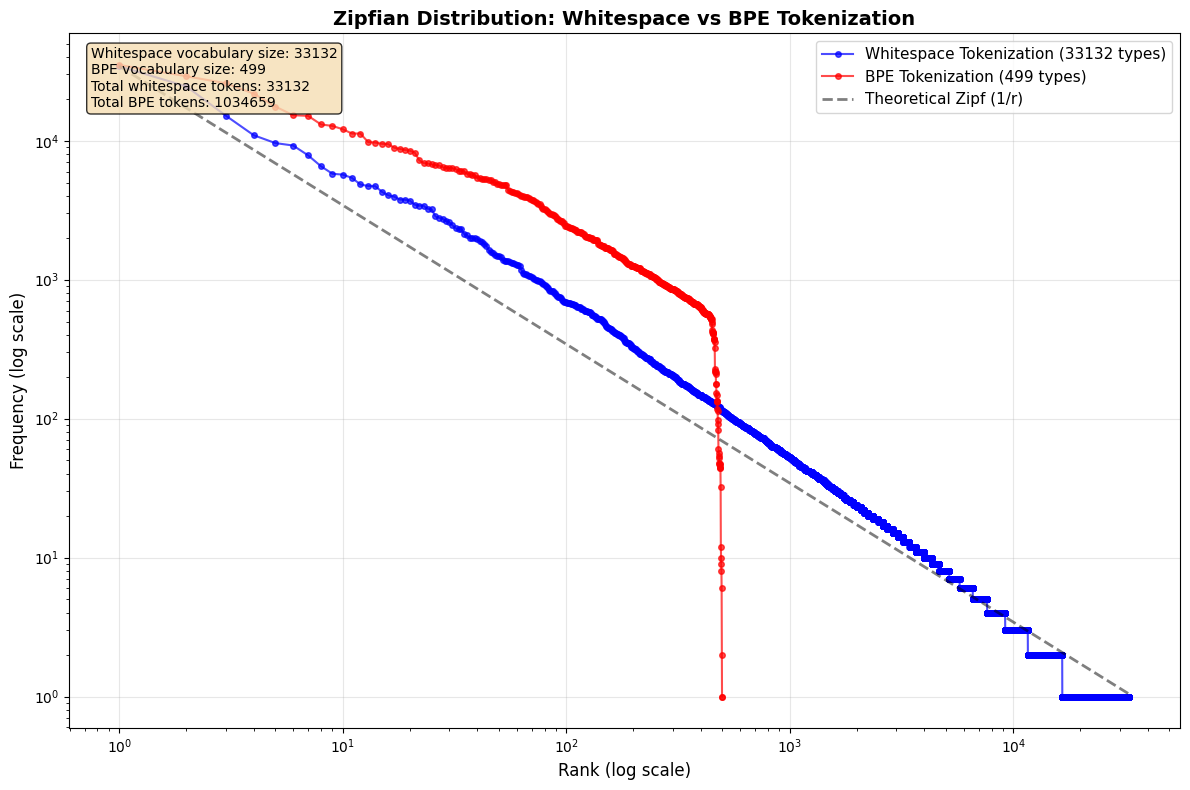


Top 10 most frequent whitespace tokens:
  'the': 34392
  'and': 24581
  'to': 15159
  'a': 10956
  'he': 9618
  'of': 9241
  'was': 7858
  'in': 6552
  'his': 5785
  'that': 5705

Top 10 most frequent BPE tokens:
  'the': 35133
  ',': 29105
  'and': 25928
  's': 21834
  'to': 17626
  'a': 15265
  '.': 15106
  't': 13102
  'd': 12782
  'he': 12105

Vocabulary size comparison:
  Whitespace: 33132 unique types
  BPE: 499 unique types
  BPE learned 415 merge rules


In [34]:
# TODO: Use this space to generate your Zipfian plot.
bpe_tokens = []
i = 0
for text in en_corpus:
    bpe_tokens.extend(bpe_tokenizer.tokenize(text))
    i += 1
    if i % 100 == 0:
        print(i) # progress indicator

# show most common
token_counts = Counter(bpe_tokens)
print(token_counts.most_common(10))

# Count word types for both methods
whitespace_counts = Counter(freq_dic)
bpe_counts = Counter(bpe_tokens)

# Get frequency distributions
whitespace_freqs = sorted(whitespace_counts.values(), reverse=True)
bpe_freqs = sorted(bpe_counts.values(), reverse=True)

# Create ranks
whitespace_ranks = range(1, len(whitespace_freqs) + 1)
bpe_ranks = range(1, len(bpe_freqs) + 1)

# Create the log-log plot
plt.figure(figsize=(12, 8))

plt.loglog(whitespace_ranks, whitespace_freqs, 'bo-', alpha=0.7, 
           label=f'Whitespace Tokenization ({len(whitespace_counts)} types)', markersize=4)
plt.loglog(bpe_ranks, bpe_freqs, 'ro-', alpha=0.7, 
           label=f'BPE Tokenization ({len(bpe_counts)} types)', markersize=4)

# Add theoretical Zipf distribution for comparison
zipf_theoretical = [whitespace_freqs[0] / r for r in whitespace_ranks]
plt.loglog(whitespace_ranks, zipf_theoretical, 'k--', alpha=0.5, 
           label='Theoretical Zipf (1/r)', linewidth=2)

plt.xlabel('Rank (log scale)', fontsize=12)
plt.ylabel('Frequency (log scale)', fontsize=12)
plt.title('Zipfian Distribution: Whitespace vs BPE Tokenization', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Add some statistics
plt.text(0.02, 0.98, f'Whitespace vocabulary size: {len(whitespace_counts)}\n'
                     f'BPE vocabulary size: {len(bpe_counts)}\n'
                     f'Total whitespace tokens: {len(freq_dic)}\n'
                     f'Total BPE tokens: {len(bpe_tokens)}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# Print top 10 most frequent tokens for each method
print("\nTop 10 most frequent whitespace tokens:")
for token, freq in whitespace_counts.most_common(10):
    print(f"  '{token}': {freq}")

print("\nTop 10 most frequent BPE tokens:")
for token, freq in bpe_counts.most_common(10):
    print(f"  '{token}': {freq}")

print(f"\nVocabulary size comparison:")
print(f"  Whitespace: {len(whitespace_counts)} unique types")
print(f"  BPE: {len(bpe_counts)} unique types")
print(f"  BPE learned {len(bpe_tokenizer.merges)} merge rules")

## Part 2: Word embeddings (25 points)

In this part, you will implement the Skip-Gram model to compute word embeddings for the words in your corpus.

### Part 2.0: Setup
For the remainder of the assignment, we will use `ByteLevelBPETokenizer` from the `tokenizers` library. 

In [4]:
# from tokenizers import decoders
def get_tokenizer(data_path: str, vocab_size=10000):
    tokenizer = ByteLevelBPETokenizer()
    tokenizer.normalizer = Lowercase()

    tokenizer.train(files=data_path, vocab_size=vocab_size, min_frequency=2, special_tokens=["<BOS>", "<EOS>"])

    return tokenizer

en_tokenizer = get_tokenizer("data/stories.txt")
en_tokenized = [en_tokenizer.encode(s).ids for s in en_corpus]

### Part 2.1: Experiment with different contexts (5 points)

First, let's explore different implementations of context for the Skip-Gram model.

**Implement:** Two functions that map from tokenized sentences and words to contexts:

##### a)  **Bag-of-Words Context** 
The first function should, for each target token $w$, create a positive example $(w, c)$ for every additional token $c$ in the sentence. 

I.e., for a sentence $\langle x_1, \dots, x_m \rangle$ of length $m$ tokens, we should create $m \cdot (m - 1)$ positive examples: $\bigcup_{1 \leq i \leq m} \bigcup_{1 \leq j \leq m, i \neq j} \left\{ (x_i, x_j) \right\}$.
   
##### b)  **Neighboring Tokens Context** 

The second function should, for each target token $w$, create a positive example $(w, c)$ for each of the tokens within a window of up to size $N$ before and after the target token's index. 

I.e., for a sentence $\langle x_1, \dots, x_m \rangle$ of length $m$ tokens, we should create $m \cdot 2N$ positive examples: $\bigcup_{1 \leq i \leq m}\bigcup_{1 \leq j \leq N}\{ (x_i, (-j, x_{i-j})), (x_i, (j, x_{i + j}) )\}$. 

Here, contexts are  not just individual wordtypes, but the wordtypes are paired with some positive or negative distance away from the target token. For cases where the window is out of bounds of the sentence (i.e., $i - j < 1$ or $i + j > m$), you can create a special wordtype (e.g., \<BOS\> or \<EOS\>).

In [5]:
def get_bow_context(tokenized_sentences: List[List[str]]) -> List[Tuple[str, str]]:
    """
    Creates positive (target, context) examples where context is any other word in the sentence.
    """
    bows = []
    for sentence in tokenized_sentences:
        m = len(sentence)
        for i in range(m):
            # grab the word itself, then form the context as everything but the word
            target = sentence[i]
            contexts = sentence[:i] + sentence[i+1:]
            for context in contexts:
                bows.append((target, context))
    
    return bows

def get_neighbor_context(tokenized_sentences: List[List[int]], window_size: int) -> List[Tuple[int, int]]:
    """
    Creates positive (target, context) examples from tokens within a given window size.
    """
    contexts = []
    for sentence in tokenized_sentences:
        m = len(sentence)
        for i in range(m):
            target = sentence[i]
            
            for j in range(i - window_size, i + window_size + 1):
                if j == i:  # skip itself
                    continue
                    
                # handle BOS/EOS edge cases
                if j < 0:
                    context = en_tokenizer.token_to_id('<BOS>')
                elif j >= m:
                    context = en_tokenizer.token_to_id('<EOS>')
                else:
                    context = sentence[j]
                    
                # assert isinstance(context, int), f"{context} is not an int"
                
                contexts.append((target, context))
    
    return contexts

In [115]:
print(en_tokenizer.encode('B'))

Encoding(num_tokens=1, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])


#### 💾 Save your results for `get_neighbor_context`

In [6]:
neighbor_pairs = get_neighbor_context(en_tokenized, window_size=2)
save_results(neighbor_pairs[:10000], 'neighbor_context.json')
print("Saved results for get_neighbor_context.")

Saved results for get_neighbor_context.


In [7]:
bow_pairs = get_bow_context(en_tokenized)
save_results(bow_pairs[:10000], 'bow_context.json')
print("Saved results for get_bow_context.")

Saved results for get_bow_context.


### Part 2.3: Negative sampling (5 points)
To train the Skip-Gram model efficiently, we use negative sampling. First, we model the probability distribution over contexts.

**Implement:** A function that computes a distribution over the contexts $\mathcal{C}$ given a dataset of word-context pairs $\mathcal{D}$.

In [6]:
def get_context_distribution(pairs, vocab_size: int) -> List[float]:
    """
    Computes the probability distribution over contexts P(c).

    Args:
        pairs: A list of (token, context) pairs.
        vocab_size: The size of the vocabulary.

    Returns:
        A list of probabilities for each context token, ordered by token index.
    """
    context_counts = [0] * (vocab_size + 2)
    
    # Count occurrences of each context
    for target, context in pairs:
        # neighbors is ints
        if isinstance(context, tuple):
            context_token = context[1]
            if isinstance(context_token, int) and 0 <= context_token < vocab_size:
                context_counts[context_token] += 1
            elif context_token == en_tokenizer.token_to_id('<BOS>'):
                context_counts[vocab_size] += 1
            elif context_token == en_tokenizer.token_to_id('<EOS>'):
                context_counts[vocab_size + 1] += 1
        # BOW is strs
        else:
            if isinstance(context, int) and 0 <= context < vocab_size:
                context_counts[context] += 1
    
    # Convert counts to probabilities
    total_count = sum(context_counts)
    if total_count == 0:
        return [1.0 / vocab_size] * vocab_size
    
    probabilities = [count / total_count for count in context_counts]
    return probabilities


**Implement:** A function for sampling negative pairs of tokens and contexts given the prior over contexts $\mathcal{C}$.

In [7]:

def sample_negative_contexts(context_distribution: torch.Tensor, num_samples: int, batch_size=1) -> torch.Tensor:
    """
    Samples negative contexts based on the context distribution.
    """
    # normalization necessary?
    if not torch.allclose(context_distribution.sum(), torch.tensor(1.0), atol=1e-6):
        context_distribution = context_distribution / context_distribution.sum()
    
    # Sample from multinomial distribution
    # multinomial expects (batch_size, num_classes) but we have (vocab_size,)
    # We expand to (batch_size, vocab_size) and sample num_samples from each row
    expanded_dist = context_distribution.unsqueeze(0).expand(batch_size, -1)
    
    # Sample negative contexts
    # multinomial returns indices of the sampled categories
    negative_samples = torch.multinomial(expanded_dist, num_samples=num_samples, replacement=True)

    return negative_samples


In [10]:
def convert_pairs_to_ids(pairs: List[Tuple[str, str]], 
                        vocab_to_id: dict) -> List[Tuple[int, int]]:
    """
    Convert word-based pairs to token ID pairs.
    Args:
        pairs: List of (target_word, context_word) pairs.
        vocab_to_id: Dictionary mapping words to token IDs.
    Returns:
        List of (target_id, context_id) pairs.
    """
    id_pairs = []
    for target, context in pairs:
        if target in vocab_to_id and context in vocab_to_id:
            target_id = vocab_to_id[target]
            context_id = vocab_to_id[context]
            id_pairs.append((target_id, context_id))
    return id_pairs

def analyze_highest_probability_negatives(tokenized_sentences: List[List[str]], 
                                       vocab_to_id: dict,
                                       id_to_vocab: dict) -> dict:
    """
    For each context setting, find the highest-probability negative sample.
    
    Args:
        tokenized_sentences: List of tokenized sentences (words as strings)
        vocab_to_id: Dictionary mapping words to token IDs
        id_to_vocab: Dictionary mapping token IDs to words
        
    Returns:
        Dictionary with results for each context setting
    """
    vocab_size = len(vocab_to_id)
    results = {}
    
    print("="*60)
    print("ANALYZING HIGHEST-PROBABILITY NEGATIVE SAMPLES")
    print("="*60)
    
    # 1. BAG OF WORDS CONTEXT
    print("\n1. BAG OF WORDS CONTEXT")
    print("-" * 30)
    
    # Generate BOW context pairs (as strings)
    bow_string_pairs = get_bow_context(tokenized_sentences)
    print(f"Generated {len(bow_string_pairs)} BOW string pairs")
    
    # Convert to token ID pairs
    bow_id_pairs = convert_pairs_to_ids(bow_string_pairs, vocab_to_id)
    print(f"Converted to {len(bow_id_pairs)} BOW ID pairs")
    
    # Get context distribution
    bow_distribution = get_context_distribution(bow_id_pairs, vocab_size)
    
    # Find highest probability context
    max_prob_idx = bow_distribution.index(max(bow_distribution))
    max_prob = bow_distribution[max_prob_idx]
    max_prob_word = id_to_vocab[max_prob_idx]
    
    print(f"Highest-probability negative: '{max_prob_word}' (ID: {max_prob_idx}, P = {max_prob:.4f})")
    
    results['bag_of_words'] = {
        'word': max_prob_word,
        'token_id': max_prob_idx,
        'probability': max_prob,
        'total_pairs': len(bow_id_pairs)
    }
    
    # 2. NEIGHBORING TOKENS N=1
    print("\n2. NEIGHBORING TOKENS N=1")
    print("-" * 30)
    
    # Convert sentences to token IDs first
    tokenized_sentences_ids = []
    for sentence in tokenized_sentences:
        sentence_ids = [vocab_to_id[word] for word in sentence if word in vocab_to_id]
        tokenized_sentences_ids.append(sentence_ids)
    
    # Generate neighbor context pairs N=1
    neighbor_1_pairs = get_neighbor_context(tokenized_sentences_ids, window_size=1)
    print(f"Generated {len(neighbor_1_pairs)} neighbor pairs (N=1)")
    
    # Get context distribution (this handles the tuple format)
    neighbor_1_distribution = get_context_distribution(neighbor_1_pairs, vocab_size)
    
    # Find highest probability context
    max_prob_idx_n1 = neighbor_1_distribution.index(max(neighbor_1_distribution))
    max_prob_n1 = neighbor_1_distribution[max_prob_idx_n1]
    max_prob_word_n1 = id_to_vocab[max_prob_idx_n1]
    
    print(f"Highest-probability negative: '{max_prob_word_n1}' (ID: {max_prob_idx_n1}, P = {max_prob_n1:.4f})")
    
    results['neighbor_n1'] = {
        'word': max_prob_word_n1,
        'token_id': max_prob_idx_n1,
        'probability': max_prob_n1,
        'total_pairs': len(neighbor_1_pairs)
    }
    
    # 3. NEIGHBORING TOKENS N=2  
    print("\n3. NEIGHBORING TOKENS N=2")
    print("-" * 30)
    
    # Generate neighbor context pairs N=2
    neighbor_2_pairs = get_neighbor_context(tokenized_sentences_ids, window_size=2)
    print(f"Generated {len(neighbor_2_pairs)} neighbor pairs (N=2)")
    
    # Get context distribution
    neighbor_2_distribution = get_context_distribution(neighbor_2_pairs, vocab_size)
    
    # Find highest probability context
    max_prob_idx_n2 = neighbor_2_distribution.index(max(neighbor_2_distribution))
    max_prob_n2 = neighbor_2_distribution[max_prob_idx_n2]
    max_prob_word_n2 = id_to_vocab[max_prob_idx_n2]
    
    print(f"Highest-probability negative: '{max_prob_word_n2}' (ID: {max_prob_idx_n2}, P = {max_prob_n2:.4f})")
    
    results['neighbor_n2'] = {
        'word': max_prob_word_n2,
        'token_id': max_prob_idx_n2,
        'probability': max_prob_n2,
        'total_pairs': len(neighbor_2_pairs)
    }
    
    # SUMMARY COMPARISON
    print("\n" + "="*60)
    print("SUMMARY: HIGHEST-PROBABILITY NEGATIVES BY CONTEXT TYPE")
    print("="*60)
    
    for context_type, result in results.items():
        print(f"{context_type:15}: '{result['word']:10}' (P = {result['probability']:.4f})")
    
    # Show some distribution statistics
    print(f"\nDistribution Statistics:")
    print(f"BOW - Non-zero contexts: {sum(1 for p in bow_distribution if p > 0)}")
    print(f"N=1 - Non-zero contexts: {sum(1 for p in neighbor_1_distribution if p > 0)}")  
    print(f"N=2 - Non-zero contexts: {sum(1 for p in neighbor_2_distribution if p > 0)}")
    
    return results

In [11]:
neighbor_1_pairs = get_neighbor_context(en_tokenized, window_size=1)
save_results(neighbor_pairs[:10000], 'neighbor_1_context.json')

In [12]:
bow_dist = get_context_distribution(bow_pairs, 10000)  

n1_dist = get_context_distribution(neighbor_1_pairs, 10000)  

n2_dist = get_context_distribution(neighbor_pairs, 10000) 


In [13]:
bow_negative = sample_negative_contexts(torch.tensor(bow_dist), 10000)
n1_negative = sample_negative_contexts(torch.tensor(n1_dist), 10000)
n2_negative = sample_negative_contexts(torch.tensor(n2_dist), 10000)

In [32]:
p, max_prob_idx = torch.max(bow_negative[0], dim=0)
max_prob_word = en_tokenizer.decode([max_prob_idx.item()])
print(f"BOW | word = {max_prob_word} | idx {max_prob_idx} | p = {p / torch.sum(bow_negative)}")

p, max_prob_idx = torch.max(n1_negative[0], dim=0)
max_prob_word = en_tokenizer.decode([max_prob_idx.item()])
print(f"N1 | word = {max_prob_word} | idx {max_prob_idx} | p = {p / torch.sum(n1_negative)}")

p, max_prob_idx = torch.max(n2_negative[0], dim=0)
max_prob_word = en_tokenizer.decode([max_prob_idx.item()])
print(f"N2 | word = {max_prob_word} | idx {max_prob_idx} | p = {p / torch.sum(n2_negative)}")

NameError: name 'bow_negative' is not defined

**Report:**

★ 2.3.1 For each of the following context settings, list the highest-probability *negative* sample according to the priors you computed:
- Context as a bag of words.
- Context as neighboring tokens, $N=1$.
- Context as neighboring tokens, $N=2$.

### Part 2.4: Train the Skip-Gram model and analyze embeddings (15 points)

Now, we'll define our Skip-Gram model and train it on our corpus.

**Implement:** A Skip-Gram model in PyTorch. The model should consist of two embedding layers: one for the target words and one for the context words.

In [24]:
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int):
        super(SkipGramModel, self).__init__()
        self.target_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, target, context):
        # target_embed = self.target_embeddings(target)  # (batch_size, embedding_dim)
        # context_embed = self.context_embeddings(context)  # (batch_size, num_contexts, embedding_dim)

        # # Expand target_embed to (batch_size, 1, embedding_dim)
        # target_embed = target_embed.unsqueeze(1)

        # # Multiply and reduce: (batch_size, num_contexts)
        # dot_product = torch.sum(target_embed * context_embed, dim=2)

        # return dot_product
        
        target_embed = self.target_embeddings(target)     # (batch_size, embedding_dim)
        context_embed = self.context_embeddings(context)  # (batch_size, embedding_dim)

        # Replace this with the cosine similarity below?
        dot_product = torch.sum(target_embed * context_embed, dim=1)  # (batch_size,)

        return dot_product

**Implement:** Train your Skip-Gram model using the tokenized data `en_tokenized`. You may want to implement batching to speed things up.


In [18]:

class SkipGramDataset(Dataset):
    def __init__(self, pairs: List[Tuple[int, int]]):
        self.pairs = pairs
        
    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return self.pairs[idx]

def train_skipgram(corpus, tokenizer, num_epochs=30):

    # Initialize the model, loss function, optimizer, and dataloader

    embedding_dim = 128
    vocab_size = len(tokenizer.get_vocab())
    model = SkipGramModel(vocab_size, embedding_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    batch_size = 2**10
    print("initialized")

    neighbor_pairs = get_neighbor_context([tokenizer.encode(s).ids for s in corpus], window_size=5)
    assert all(isinstance(t, int) and isinstance(c, int) for t, c in neighbor_pairs), \
        "Found non-integer values in neighbor_pairs"
    dataset = SkipGramDataset(neighbor_pairs)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
    )
    print("data redy to go")    

    # Training loop
    # You will need to combine positive and negative samples in the loss computation, and adjust the labels accordingly.
    context_probs = get_context_distribution(neighbor_pairs, vocab_size)
    context_distribution = torch.tensor(context_probs[:vocab_size], dtype=torch.float)

    device = torch.device("cuda")
    model = model.to(device)
    context_distribution = context_distribution.to(device)
    print("context probs/dist done")

    NUM_NEGATIVES = 10 # hyperparam
    for epoch in range(num_epochs):
        total_loss = 0

        for pos_batch in dataloader:
            target_words, context_words = pos_batch
            target_words = torch.tensor(target_words, device=device)
            context_words = torch.tensor(context_words, device=device)

            batch_size_actual = target_words.size(0)
            pos_labels = torch.ones(batch_size_actual, device=device)

            neg_contexts = sample_negative_contexts(context_distribution, num_samples=NUM_NEGATIVES, batch_size=batch_size_actual).to(device) # (batch_size, num_negatives)

            # Expand target words to match negative samples shape
            neg_targets = target_words.unsqueeze(1).expand(-1, NUM_NEGATIVES).reshape(-1)
            neg_contexts = neg_contexts.reshape(-1)
            neg_labels = torch.zeros(neg_targets.size(0), device=device)

            # Combine positive and negative examples
            all_targets = torch.cat([target_words, neg_targets], dim=0)
            all_contexts = torch.cat([context_words, neg_contexts], dim=0)
            all_labels = torch.cat([pos_labels, neg_labels], dim=0)

            # Forward pass
            scores = model(all_targets, all_contexts)
            loss = criterion(scores, all_labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss:.4f}")

    return model

In [10]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "N/A")


CUDA available: True
GPU Name: NVIDIA GeForce RTX 2070 SUPER


Test!

#### 💾 Save your model outputs

In [23]:
test_center_word = torch.tensor(np.load('data/center_word.npy')).to(device)
test_context_words = torch.tensor(np.load('data/context_words.npy')).to(device)
print("center shape:", test_center_word.shape)
print("context shape:", test_context_words.shape)


center shape: torch.Size([65536])
context shape: torch.Size([65536, 11])


In [25]:
device = torch.device("cuda")
model = train_skipgram(en_corpus, en_tokenizer, num_epochs=30)

test_center_word = torch.tensor(np.load('data/center_word.npy')).to(device)
test_context_words = torch.tensor(np.load('data/context_words.npy')).to(device)

test_center_word_expanded = test_center_word.unsqueeze(1).expand(-1, 11).reshape(-1)  # shape: [720896]
test_context_words_flat = test_context_words.reshape(-1)

test_scores = model(test_center_word_expanded, test_context_words_flat)
np.save('results/skipgram_scores.npy', test_scores.cpu().detach().numpy())

initialized
data redy to go
context probs/dist done


C:\Users\cjmc7\AppData\Local\Temp\ipykernel_28212\1017428440.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_words = torch.tensor(target_words, device=device)
C:\Users\cjmc7\AppData\Local\Temp\ipykernel_28212\1017428440.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context_words = torch.tensor(context_words, device=device)


Epoch 1/30 - Loss: 2833.9988
Epoch 2/30 - Loss: 2057.9664
Epoch 3/30 - Loss: 2029.4864
Epoch 4/30 - Loss: 2018.5019
Epoch 5/30 - Loss: 2012.6143
Epoch 6/30 - Loss: 2008.8511
Epoch 7/30 - Loss: 2006.5319
Epoch 8/30 - Loss: 2005.0539
Epoch 9/30 - Loss: 2003.8376
Epoch 10/30 - Loss: 2002.8780
Epoch 11/30 - Loss: 2002.4375
Epoch 12/30 - Loss: 2001.6936
Epoch 13/30 - Loss: 2001.2356
Epoch 14/30 - Loss: 2000.9668
Epoch 15/30 - Loss: 2000.6825
Epoch 16/30 - Loss: 2000.1829
Epoch 17/30 - Loss: 1999.7594
Epoch 18/30 - Loss: 1999.8845
Epoch 19/30 - Loss: 1999.5269
Epoch 20/30 - Loss: 1999.1777
Epoch 21/30 - Loss: 1999.5521
Epoch 22/30 - Loss: 1999.4927
Epoch 23/30 - Loss: 1999.1115
Epoch 24/30 - Loss: 1999.0467
Epoch 25/30 - Loss: 1998.7692
Epoch 26/30 - Loss: 1998.9318
Epoch 27/30 - Loss: 1999.0827
Epoch 28/30 - Loss: 1998.9084
Epoch 29/30 - Loss: 1999.2571
Epoch 30/30 - Loss: 1998.8346


**Implement:** A function that, given a trained Skip-Gram model and a target wordtype, returns the cosine similarity of that wordtype's embedding with the embedding of every other wordtype in the vocabulary.

In [1]:
def get_cosine_similarity(model: SkipGramModel, tokenizer: ByteLevelBPETokenizer, target_word: str) -> List[Tuple[str, float]]:
    """
    Given a trained model and a target word, returns a list of (word, similarity_score) 
    for all words in the vocabulary (excluding the target word), sorted by similarity score.
    """
    device = next(model.parameters()).device 
    model.eval()  

    vocab = tokenizer.get_vocab()
    id_to_token = {v: k for k, v in vocab.items()}
    target_id = vocab[target_word]

    embeddings = model.target_embeddings.weight  # shape: (vocab_size, embedding_dim)
    embeddings = torch.nn.functional.normalize(embeddings, dim=1)  # normalize each word vector

    target_vector = embeddings[target_id]  # shape: (embedding_dim,)
    target_vector = target_vector.unsqueeze(0)  # shape: (1, embedding_dim)
    similarities = torch.matmul(embeddings, target_vector.T).squeeze(1)  # shape: (vocab_size,)
    similarities[target_id] = -1.0 # exlcude actual term

    results = []
    for token_id, score in enumerate(similarities.tolist()):
        if token_id != target_id:  # Exclude the target word itself
            results.append((id_to_token[token_id], score))
    
    results.sort(key=lambda x: x[1], reverse=True)
    return results

NameError: name 'SkipGramModel' is not defined

In [31]:
print(get_cosine_similarity(model, en_tokenizer, "king"))
print(get_cosine_similarity(model, en_tokenizer, "cat"))
print(get_cosine_similarity(model, en_tokenizer, "stone"))

[('fire', 0.4045700132846832), ('Ġtiger', 0.39451003074645996), ('Ġweepest', 0.36137107014656067), ('Ġcheat', 0.3577389419078827), ('iv', 0.35148885846138), ('ined', 0.3432886004447937), ('Ġsympath', 0.34181222319602966), ('doodle', 0.3402382433414459), ('why', 0.33883023262023926), ('pped', 0.3363540768623352), ('Ġpotat', 0.3349894881248474), ('Ġcho', 0.33480799198150635), ('Ġshrie', 0.33190208673477173), ('Ġflail', 0.32769280672073364), ('leaf', 0.32663458585739136), ('Ġant', 0.3234921991825104), ('Ġbas', 0.32254141569137573), ('Ġbellissima', 0.32118096947669983), ('grand', 0.3181334137916565), ('po', 0.31706568598747253)]
[('shapen', 0.42938944697380066), ('bby', 0.4191800653934479), ('cri', 0.39097028970718384), ('Ġchick', 0.3847668766975403), ('hem', 0.38458338379859924), ('Ġswimming', 0.37649279832839966), ('Ġordinary', 0.36723393201828003), ('fine', 0.36023110151290894), ('Ġpussy', 0.35979804396629333), ('Ġbird', 0.35801854729652405), ('Ġpledge', 0.3571021854877472), ('Ġaffected

**Report:**

★ 2.4.1 Use `get_cosine_similarity` to explore similar wordtypes for different English words. Give three examples of pairs of similar wordtypes that make sense, and three that don't. What are possible reasons for a high similarity score between two seemingly unrelated words?
- Note that, for the above words, the G character is the BOS token.
- Many of the items 

## Part 3: Vector algebra (25 points)

For the remainder of this homework, you will use a modern NLP library `spaCy`. You can find its documentation [here](https://spacy.io/usage/spacy-101).

Install spaCy and its English, French, Japanese models with
```
pip install spacy
python -m spacy download en_core_web_md
python -m spacy download fr_core_news_md
python -m spacy download ja_core_news_md
```


### Part 3.0: Setup

In [ ]:
# !pip install spacy==3.7.4

  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl.metadata (23 kB)
  Using cached wasabi-1.1.3-py3-none-any.whl.metadata (28 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl.metadata (14 kB)
  Using cached weasel-0.3.4-py3-none-any.whl.metadata (4.7 kB)
  Using cached typer-0.9.4-py3-none-any.whl.metadata (14 kB)
  Using cached smart_open-6.4.0-py3-none-any.whl.metadata (21 kB)
  Using cached langcodes-3.5.0-py3-none-any.whl.metadata (29 kB)
  Using cached language_data-1.3.0-py3-none-any.whl.metadata (4.3 kB)
  Using cached confection-0.1.5-py3-none-any.whl.metadata (19 kB)
  Using cached cloudpathlib-0.16.0-py3-none-any.whl.metadata (14 kB)
   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.1 MB ? e

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyannote-database 5.1.3 requires typer>=0.12.1, but you have typer 0.9.4 which is incompatible.
whisperx 3.4.2 requires numpy>=2.0.2, but you have numpy 1.26.4 which is incompatible.


In [ ]:
# !python -m spacy download en_core_web_md
# !python -m spacy download fr_core_news_md  
# !python -m spacy download ja_core_news_md

     ---------------------------------------- 0.0/42.8 MB ? eta -:--:--
     ---------------------------------------- 0.3/42.8 MB ? eta -:--:--
     ---------------------------------------- 0.5/42.8 MB 1.5 MB/s eta 0:00:28
     ---------------------------------------- 0.5/42.8 MB 1.5 MB/s eta 0:00:28
      -------------------------------------- 0.8/42.8 MB 817.9 kB/s eta 0:00:52
      -------------------------------------- 0.8/42.8 MB 817.9 kB/s eta 0:00:52
      -------------------------------------- 1.0/42.8 MB 798.4 kB/s eta 0:00:53
     - ------------------------------------- 1.3/42.8 MB 818.6 kB/s eta 0:00:51
     - ------------------------------------- 1.6/42.8 MB 882.6 kB/s eta 0:00:47
     - ------------------------------------- 1.8/42.8 MB 923.6 kB/s eta 0:00:45
     - ------------------------------------- 2.1/42.8 MB 970.4 kB/s eta 0:00:42
     -- ------------------------------------- 2.4/42.8 MB 1.0 MB/s eta 0:00:40
     -- ------------------------------------- 2.9/42.8 MB 1

In [5]:
import spacy

nlp_en = spacy.load("en_core_web_md")
nlp_fr = spacy.load("fr_core_news_md")
nlp_ja = spacy.load("ja_core_news_md")

### Part 3.1: Word analogy (10 points)

**Implement:** A function that, given two wordtypes representing a target analogy (e.g., *cat* and *kitten*) and an input wordtype to evaluate in that analogy (e.g., *dog*), returns the wordtype that (according to the learned embeddings) best fits as the analogy. Recall the formula for finding this in the slides.

In [6]:
def solve_analogy(model, a: str, b: str, c: str, n=5) -> str:
    """
    Solves the analogy 'a is to b as c is to ?'.
    Returns the word from the vocabulary whose embedding is closest to vec(b) - vec(a) + vec(c).
    """
    vec_a = model(a).vector
    vec_b = model(b).vector
    vec_c = model(c).vector
    
    # target + normalize for no magnitude later
    target_vector = vec_b - vec_a + vec_c
    target_norm = np.linalg.norm(target_vector)
    target_vector_normalized = target_vector / target_norm
    
    # iterate over vocab
    candidates = []
    for word in model.vocab:
        word_vector = word.vector
        word_norm = np.linalg.norm(word_vector)
        
        if word_norm == 0: # debug case
            continue
            
        word_vector_normalized = word_vector / word_norm
        similarity = np.dot(target_vector_normalized, word_vector_normalized)
        
        candidates.append((word.text, similarity))
    
    # debug case
    if not candidates:
        return ""
    
    candidates.sort(key=lambda x: x[1], reverse=True)

    i = 0
    while candidates[i][0] == a or candidates[i][0] == b or candidates[i][0] == c:
        i += 1
    return candidates[i][0]

#### 💾 Save your results for `solve_analogy`

In [47]:
test_analogies = [
    # Your existing test cases
    ("king", "queen", "man", "woman"),
    ("paris", "france", "berlin", "germany"),
    ("car", "driver", "train", "conductor"),
    ("good", "better", "bad", "worse"),
    ("big", "bigger", "small", "smaller"),
    ("dog", "puppy", "cat", "kitty"),
    
    # Geographic relationships
    ("tokyo", "japan", "london", "england"),
    ("madrid", "spain", "rome", "italy"),
    ("moscow", "russia", "beijing", "china"),
    
    # Family relationships
    ("father", "mother", "son", "daughter"),
    ("uncle", "aunt", "nephew", "niece"),
    ("husband", "wife", "brother", "sister"),
    
    # Animal relationships
    ("cow", "calf", "horse", "foal"),
    ("lion", "lioness", "tiger", "tigress"),
    ("rooster", "hen", "duck", "duck"),  # This one might be tricky!
    
    # Profession/tool relationships
    ("doctor", "stethoscope", "chef", "knife"),
    ("painter", "brush", "musician", "instrument"),
    ("teacher", "blackboard", "farmer", "plow"),
    
    # Size/scale relationships
    ("tiny", "huge", "hot", "cold"),
    ("mountain", "hill", "ocean", "lake"),
    ("giant", "dwarf", "loud", "quiet"),
    
    # Time relationships
    ("day", "night", "summer", "winter"),
    ("morning", "evening", "beginning", "end"),
    ("young", "old", "new", "old"),
    
    # Part-to-whole relationships
    ("finger", "hand", "toe", "foot"),
    ("wheel", "car", "wing", "airplane"),
    ("page", "book", "brick", "wall"),
    
    # Grammatical relationships
    ("walk", "walked", "run", "ran"),
    ("sing", "sang", "bring", "brought"),
    ("happy", "happiness", "sad", "sadness"),
    
    # Synonyms/antonyms
    ("begin", "start", "finish", "end"),
    ("fast", "quick", "slow", "gradual"),
    ("love", "adore", "hate", "despise"),
    
    # Function relationships
    ("key", "lock", "password", "account"),
    ("fuel", "car", "food", "body"),
    ("water", "thirst", "sleep", "fatigue"),
    
    # Quantity relationships
    ("one", "single", "two", "double"),
    ("few", "many", "little", "much"),
    ("first", "last", "beginning", "end"),
    
    # Material/composition
    ("wood", "table", "metal", "spoon"),
    ("glass", "window", "fabric", "curtain"),
    ("leather", "shoe", "cotton", "shirt"),
    
    # Action/result relationships
    ("study", "knowledge", "practice", "skill"),
    ("exercise", "fitness", "rest", "recovery"),
    ("plant", "growth", "destroy", "ruin"),
    
    # Challenging/ambiguous cases (good for testing robustness)
    ("north", "south", "east", "west"),
    ("input", "output", "question", "answer"),
    ("problem", "solution", "disease", "cure"),
]


analogy_results = []
for a, b, c, expected in test_analogies:
    result = solve_analogy(nlp_en, a, b, c)
    analogy_results.append(result)
    print(f"{a}:{b}::{c}:? -> {result} (expected: {expected})")

save_results(analogy_results, 'solve_analogy.json')

king:queen::man:? -> she (expected: woman)
paris:france::berlin:? -> moscow (expected: germany)
car:driver::train:? -> practice (expected: conductor)
good:better::bad:? -> bigger (expected: worse)
big:bigger::small:? -> solution (expected: smaller)
dog:puppy::cat:? -> rooster (expected: kitty)
tokyo:japan::london:? -> spain (expected: england)
madrid:spain::rome:? -> E.G. (expected: italy)
moscow:russia::beijing:? -> france (expected: china)
father:mother::son:? -> wife (expected: daughter)
uncle:aunt::nephew:? -> wife (expected: niece)
husband:wife::brother:? -> father (expected: sister)
cow:calf::horse:? -> shoe (expected: foal)
lion:lioness::tiger:? -> rooster (expected: tigress)
rooster:hen::duck:? -> cow (expected: duck)
doctor:stethoscope::chef:? -> Ia (expected: knife)
painter:brush::musician:? -> finger (expected: instrument)
teacher:blackboard::farmer:? -> wood (expected: plow)
tiny:huge::hot:? -> big (expected: cold)
mountain:hill::ocean:? -> east (expected: lake)
giant:dwarf

**Report:**

★ 3.1.1 Find three analogies in English that the model is able to solve correctly, and three analogies in English where the model gives a wrong answer.
- After throwing in some extraneous cases, we can see the following:
- Correct (relatively):
    - king:queen::man:? -> she (expected: woman) -- gender is well captured across nouns
    - water:thirst::sleep:? -> o.O (expected: fatigue) -- somehow was able to categorize an emoticon (with *some* accuracy too)
    - finger:hand::toe:? -> shoe (expected: foot) -- part of body somewhat accurately captured

- Incorrect:
    - tiny : huge  ::  hot : big (expected: cold) -- the model can get stuck in loops involving original word context, despite the analogy equation being supposed to remove this. This implies that the learned model doesn't quite have enough parameters or training data to isolate "size", for example, as it's own portion of the vector.
    - tokyo:japan::london:? -> spain (expected: england) -- while locations are regularly grouped together, it doesn't quite have the resolution to distinguish between them in many cases
    - walk:walked::run:? -> had (expected: ran) -- past tense is strongly learned into the participle, likely overshadowing the actual past tense of the verb in question
    


### 3.2 Embedding alignment (15 points)

**Implement:** A function that identifies the transformation $W$ that best aligns two embedding spaces given a parallel corpus and a parallel word.

In [ ]:
from spacy.language import Language

def learn_translation_matrix(
    nlp_src: Language,
    nlp_tgt: Language,
    word_pairs: List[List[str]]
) -> np.ndarray:
    """
    Learns a linear transformation matrix W that maps source language vectors to target language vectors.
    Input:
        nlp_src: spaCy Language object for the source language.
        nlp_tgt: spaCy Language object for the target language.
        word_pairs: A list of [source_word, target_word] pairs.
    Output:
        W: A numpy array of shape (d, d) where d is the embedding dimension
    """

    # 1. Create the training matrices X (Source) and Y (Target)
    X_list = []
    Y_list = []
    for src_word, tgt_word in word_pairs:
        if nlp_src.vocab[src_word].has_vector and nlp_tgt.vocab[tgt_word].has_vector:
            # Normalize vectors to focus on direction
            src_vector = nlp_src.vocab[src_word].vector
            tgt_vector = nlp_tgt.vocab[tgt_word].vector
            X_list.append(src_vector / np.linalg.norm(src_vector))
            Y_list.append(tgt_vector / np.linalg.norm(tgt_vector))

    X = np.array(X_list)
    Y = np.array(Y_list)
    
    # 2. Learn the transformation matrix W where WX ≈ Y
    # TODO: Implement this
    W = Y.T @ np.linalg.pinv(X.T)
    return W

def learn_reverse_translation_matrix(
    nlp_src: Language,  # technically tgt
    nlp_tgt: Language,  # technically src
    word_pairs: List[List[str]]  # [english_word, target_word]
) -> np.ndarray:
    X_list = []
    Y_list = []
    for en_word, tgt_word in word_pairs:  # ← swapped for reverse
        if nlp_tgt.vocab[en_word].has_vector and nlp_src.vocab[tgt_word].has_vector:
            en_vector = nlp_tgt.vocab[en_word].vector
            tgt_vector = nlp_src.vocab[tgt_word].vector

            X_list.append(tgt_vector / np.linalg.norm(tgt_vector))
            Y_list.append(en_vector / np.linalg.norm(en_vector))
    
    X = np.array(X_list)
    Y = np.array(Y_list)
    W_reverse = Y.T @ np.linalg.pinv(X.T)
    return W_reverse

def translate_with_matrix(
    nlp_src: Language, nlp_tgt: Language, W: np.ndarray, word: str
):
    """
    Translates a word from the source language to the target language using the learned matrix W.
    Input:
        nlp_src: spaCy Language object for the source language.
        nlp_tgt: spaCy Language object for the target language.
        W: The learned transformation matrix.
        word: The source language word to translate.
    Output:
        predicted_word: The translated word in the target language.
    """
    src_vec = nlp_src.vocab[word].vector
    src_vec_norm = src_vec / np.linalg.norm(src_vec)

    tgt_vec_pred = W @ src_vec_norm
    tgt_vec_pred_norm = tgt_vec_pred / np.linalg.norm(tgt_vec_pred)

    all_tgt_vectors = nlp_tgt.vocab.vectors.data
    all_tgt_vectors_norm = all_tgt_vectors / np.linalg.norm(all_tgt_vectors, axis=1, keepdims=True)

    similarities = np.dot(all_tgt_vectors_norm, tgt_vec_pred_norm)
    best_match_index = np.argmax(similarities)

    hash_value = list(nlp_tgt.vocab.vectors.keys())[best_match_index]
    predicted_word = nlp_tgt.vocab.strings[hash_value]
    return predicted_word



#### 💾 Save your results for `learn_translation_matrix`

In [20]:
en_ja = json.load(open('data/en-ja.json'))
en_fr = json.load(open('data/en-fr.json'))

W_en_fr = learn_translation_matrix(nlp_en, nlp_fr, en_fr)
W_en_ja = learn_translation_matrix(nlp_en, nlp_ja, en_ja)


W_fr_en = learn_reverse_translation_matrix(nlp_fr, nlp_en, en_fr)
W_ja_en = learn_reverse_translation_matrix(nlp_ja, nlp_en, en_ja)
np.save('results/W_fr_en.npy', W_fr_en)
np.save('results/W_ja_en.npy', W_ja_en)

# Save your matrices
np.save('results/W_en_fr.npy', W_en_fr)
np.save('results/W_en_ja.npy', W_en_ja)
print("Saved translation matrices.")

Saved translation matrices.


**Report:** Generate transformation matrices to translate between English<->Japanese and English<->French.

★ 3.2.1 What happens when you translate each of these English words to Japanese/French, then back to English?

FRENCH: penguin --> éléphant (elephant) --> elephant
JAPANESE: penguin --> 海 (sea) --> ocean


FRENCH: cheese --> fromage (cheese) --> sausage
JAPANESE: cheese --> 美味しい (delicious) --> delicious


FRENCH: sofa --> canapé (couch) --> sofa
JAPANESE: sofa --> ソファー (sofa) --> bed


FRENCH: jacket --> pantalon (pants) --> sleeves
JAPANESE: jacket --> 上着 (jacket, coat) --> clothing


FRENCH: website --> internet --> internet
JAPANESE: website --> インターネット (internet) --> internet

Along with a reverse-trained translation matrix, almost every translation works (even if some nuance is lost)! The most interesting one is "cheese" being translated to "delicious" in Japanese, which is a somewhat culturally-linked translation with it being a food only really consumed on "delicious cheese"-flavored things, rather than the actual thing.

In [21]:
en_words = [
    "penguin",
    "cheese",
    "sofa",
    "jacket",
    "website"
]

# TODO: Use this space to translate the words above using your learned matrices.
for word in en_words:
    french = translate_with_matrix(nlp_en, nlp_fr, W_en_fr, word)
    frback = translate_with_matrix(nlp_fr, nlp_en, W_fr_en, french)
    print(f"FRENCH: {word} --> {french} --> {frback}")
    japanese = translate_with_matrix(nlp_en, nlp_ja, W_en_ja, word)
    jaback = translate_with_matrix(nlp_ja, nlp_en, W_ja_en, japanese)
    print(f"JAPANESE: {word} --> {japanese} --> {jaback}")
    print("\n")



FRENCH: penguin --> éléphant --> elephant
JAPANESE: penguin --> 海 --> ocean


FRENCH: cheese --> fromage --> sausage
JAPANESE: cheese --> 美味しい --> delicious


FRENCH: sofa --> canapé --> sofa
JAPANESE: sofa --> ソファー --> bed


FRENCH: jacket --> pantalon --> sleeves
JAPANESE: jacket --> 上着 --> clothing


FRENCH: website --> internet --> internet
JAPANESE: website --> インターネット --> internet




## Part 4: Computational linguistics (25 points)

In this part, you will use `spaCy` to perform linguistic analysis on our corpus. 

Use the English model from spaCy `nlp_en` to:

(a) tokenize
(b) lemmatize
(c) get dependency trees 

the first 1000 sentences in our corpus `en_corpus`.

**Report:**

A *lemma* is the canonical or dictionary form of a word, representing the base from which all its inflected forms are derived. In NLP, the process of lemmatization groups these various forms (e.g., ran, runs, running) under their single shared lemma (run) to normalize text and simplify analysis.

★ 4.1.1 Report the 10 most frequent verb lemmas in the corpus.
1. say             -  5771 occurrences
 2. go              -  3952 occurrences
 3. have            -  2978 occurrences
 4. come            -  2910 occurrences
 5. see             -  2285 occurrences
 6. take            -  1984 occurrences
 7. do              -  1676 occurrences
 8. give            -  1510 occurrences
 9. make            -  1279 occurrences
10. get             -  1273 occurrences

★ 4.1.2 For the top 5 most frequent verb lemmas, show the distribution of their subject lemmas (i.e. by navigating the dependency tree from the root to find the `nsubj` item).
1. Verb: 'say' (5771 occurrences)
   Total subjects found: 4503
   Top 10 subjects:
       1. he              -  817 ( 18.1%)
       2. she             -  420 (  9.3%)
       3. they            -  148 (  3.3%)
       4. man             -  137 (  3.0%)
       5. King            -  122 (  2.7%)
       6. woman           -  110 (  2.4%)
       7. I               -   86 (  1.9%)
       8. mother          -   68 (  1.5%)
       9. father          -   65 (  1.4%)
      10. son             -   57 (  1.3%)

2. Verb: 'go' (3952 occurrences)
   Total subjects found: 2641
   Top 10 subjects:
       1. he              -  596 ( 22.6%)
       2. I               -  299 ( 11.3%)
       3. she             -  255 (  9.7%)
       4. they            -  247 (  9.4%)
       5. you             -  112 (  4.2%)
       6. we              -   90 (  3.4%)
       7. it              -   68 (  2.6%)
       8. who             -   52 (  2.0%)
       9. man             -   41 (  1.6%)
      10. thou            -   26 (  1.0%)

3. Verb: 'have' (2978 occurrences)
   Total subjects found: 2489
   Top 10 subjects:
       1. I               -  468 ( 18.8%)
       2. he              -  447 ( 18.0%)
       3. she             -  221 (  8.9%)
       4. you             -  190 (  7.6%)
       5. they            -  165 (  6.6%)
       6. who             -  158 (  6.3%)
       7. we              -   82 (  3.3%)
       8. thou            -   46 (  1.8%)
       9. one             -   45 (  1.8%)
      10. it              -   42 (  1.7%)

4. Verb: 'come' (2910 occurrences)
   Total subjects found: 2334
   Top 10 subjects:
       1. he              -  308 ( 13.2%)
       2. they            -  188 (  8.1%)
       3. she             -  123 (  5.3%)
       4. I               -  119 (  5.1%)
       5. it              -   98 (  4.2%)
       6. you             -   92 (  3.9%)
       7. who             -   56 (  2.4%)
       8. man             -   56 (  2.4%)
       9. one             -   43 (  1.8%)
      10. time            -   31 (  1.3%)

5. Verb: 'see' (2285 occurrences)
   Total subjects found: 1493
   Top 10 subjects:
       1. he              -  386 ( 25.9%)
       2. I               -  235 ( 15.7%)
       3. she             -  181 ( 12.1%)
       4. you             -  150 ( 10.0%)
       5. they            -  110 (  7.4%)
       6. one             -   44 (  2.9%)
       7. we              -   37 (  2.5%)
       8. thou            -   31 (  2.1%)
       9. King            -   25 (  1.7%)
      10. who             -   20 (  1.3%)

★ 4.1.3 Based on your findings, do you observe any relationship between the types of verbs and the types of subjects they take (e.g., are certain verbs more likely to have animate subjects like 'man' or 'I', versus inanimate subjects like 'door' or 'it')? Discuss one interesting example.
- Some verbs are definitely dominated more than others by animate subjects. After taking a closer look at the top 5 lemmas (from the above part), we can see two drastically different examples:
    - "come" has 12.4% inanimate subjects, made up of tokens such as "it", "time", etc.
    - "see" on the other hand has far fewer, with none of the top 10 subjects being inanimate.
- This makes sense, marking a separation between more "active" verbs that involve a sentient subject, compared to more "passive" verbs that simply represent a transformation, such as "come".

In [9]:
en_corpus_mini = en_corpus[:1000]

def analyze_corpus(en_corpus, nlp_en, num_sentences=1000):
    """
    Performs linguistic analysis on the corpus.
    
    Input:
        en_corpus: List of English sentences
        nlp_en: spaCy English language model
        num_sentences: Number of sentences to analyze (default 1000)
    
    Returns:
        docs: List of processed spaCy Doc objects
        verb_lemmas: Counter of verb lemmas
        verb_subjects: Dictionary mapping verb lemmas to their subject lemmas
    """
    # Process first 1000 sentences
    sentences = en_corpus[:num_sentences]
    
    # Process all sentences (tokenize, lemmatize, get dependency trees)
    print(f"Processing {len(sentences)} sentences...")
    docs = list(nlp_en.pipe(sentences))
    
    # Collect verb lemmas and their subjects
    verb_lemmas = Counter()
    verb_subjects = defaultdict(list)
    
    for doc in docs:
        for token in doc:
            # Check if token is a verb
            if token.pos_ == "VERB":
                verb_lemma = token.lemma_
                verb_lemmas[verb_lemma] += 1
                
                # Find the subject of this verb
                for child in token.children:
                    if child.dep_ == "nsubj":  # nominal subject
                        subject_lemma = child.lemma_
                        verb_subjects[verb_lemma].append(subject_lemma)
    
    return docs, verb_lemmas, verb_subjects


def report_top_verbs(verb_lemmas, top_n=10):
    """
    Report the top N most frequent verb lemmas.
    
    4.1.1: Report the 10 most frequent verb lemmas
    """
    print(f"\n{'='*60}")
    print(f"4.1.1: Top {top_n} Most Frequent Verb Lemmas")
    print(f"{'='*60}")
    
    top_verbs = verb_lemmas.most_common(top_n)
    for rank, (verb, count) in enumerate(top_verbs, 1):
        print(f"{rank:2d}. {verb:15s} - {count:5d} occurrences")
    
    return top_verbs


def report_subject_distributions(verb_subjects, top_verbs, top_n=5):
    """
    Report subject distributions for top N verbs.
    
    4.1.2: Show distribution of subject lemmas for top 5 verb lemmas
    """
    print(f"\n{'='*60}")
    print(f"4.1.2: Subject Distributions for Top {top_n} Verb Lemmas")
    print(f"{'='*60}")
    
    for rank in range(min(top_n, len(top_verbs))):
        verb, verb_count = top_verbs[rank]
        subjects = verb_subjects[verb]
        
        print(f"\n{rank+1}. Verb: '{verb}' ({verb_count} occurrences)")
        print(f"   Total subjects found: {len(subjects)}")
        
        if subjects:
            subject_counts = Counter(subjects)
            top_subjects = subject_counts.most_common(10)
            
            print(f"   Top 10 subjects:")
            for subj_rank, (subject, count) in enumerate(top_subjects, 1):
                percentage = (count / len(subjects)) * 100
                print(f"      {subj_rank:2d}. {subject:15s} - {count:4d} ({percentage:5.1f}%)")
        else:
            print("   No subjects found in dependency trees")


def analyze_verb_subject_relationships(verb_subjects, top_verbs):
    """
    Analyze relationships between verb types and subject types.
    
    4.1.3: Discuss relationships between verbs and their subjects
    """
    print(f"\n{'='*60}")
    print(f"4.1.3: Analysis of Verb-Subject Relationships")
    print(f"{'='*60}")
    
    # Define some common animate and inanimate subjects
    animate_pronouns = {'i', 'you', 'he', 'she', 'we', 'they', 'who'}
    animate_nouns = {'man', 'woman', 'person', 'people', 'child', 'boy', 'girl', 
                     'man', 'woman', 'someone', 'anybody', 'everyone'}
    inanimate_pronouns = {'it', 'this', 'that', 'what', 'which'}
    inanimate_nouns = {'door', 'thing', 'house', 'car', 'book', 'room', 'place'}
    
    print("\nAnalyzing animacy of subjects for top 5 verbs:\n")
    
    for rank in range(min(5, len(top_verbs))):
        verb, _ = top_verbs[rank]
        subjects = verb_subjects[verb]
        
        if not subjects:
            continue
            
        # Count animate vs inanimate subjects
        animate_count = 0
        inanimate_count = 0
        
        for subject in subjects:
            subj_lower = subject.lower()
            if subj_lower in animate_pronouns or subj_lower in animate_nouns:
                animate_count += 1
            elif subj_lower in inanimate_pronouns or subj_lower in inanimate_nouns:
                inanimate_count += 1
        
        total_classified = animate_count + inanimate_count
        if total_classified > 0:
            animate_pct = (animate_count / total_classified) * 100
            inanimate_pct = (inanimate_count / total_classified) * 100
            
            print(f"Verb: '{verb}'")
            print(f"  Animate subjects:   {animate_count:4d} ({animate_pct:5.1f}%)")
            print(f"  Inanimate subjects: {inanimate_count:4d} ({inanimate_pct:5.1f}%)")
            print(f"  Ratio (animate/inanimate): {animate_count/max(inanimate_count, 1):.2f}")
            print()

# Main execution function
def run_full_analysis(en_corpus, nlp_en):
    """
    Run complete linguistic analysis pipeline.
    """
    # Perform analysis
    docs, verb_lemmas, verb_subjects = analyze_corpus(en_corpus, nlp_en, num_sentences=len(en_corpus))
    
    # 4.1.1: Report top 10 verb lemmas
    top_verbs = report_top_verbs(verb_lemmas, top_n=10)
    
    # 4.1.2: Report subject distributions for top 5 verbs
    report_subject_distributions(verb_subjects, top_verbs, top_n=5)
    
    # 4.1.3: Analyze verb-subject relationships
    analyze_verb_subject_relationships(verb_subjects, top_verbs)
    
    # 4.1.3: Discussion
    # we will be doing this ourselves.........
    
    return docs, verb_lemmas, verb_subjects


docs, verb_lemmas, verb_subjects = run_full_analysis(en_corpus, nlp_en)
# print(docs)
print(verb_lemmas)
print(verb_subjects)

Processing 10000 sentences...

4.1.1: Top 10 Most Frequent Verb Lemmas
 1. say             -  5771 occurrences
 2. go              -  3952 occurrences
 3. have            -  2978 occurrences
 4. come            -  2910 occurrences
 5. see             -  2285 occurrences
 6. take            -  1984 occurrences
 7. do              -  1676 occurrences
 8. give            -  1510 occurrences
 9. make            -  1279 occurrences
10. get             -  1273 occurrences

4.1.2: Subject Distributions for Top 5 Verb Lemmas

1. Verb: 'say' (5771 occurrences)
   Total subjects found: 4503
   Top 10 subjects:
       1. he              -  817 ( 18.1%)
       2. she             -  420 (  9.3%)
       3. they            -  148 (  3.3%)
       4. man             -  137 (  3.0%)
       5. King            -  122 (  2.7%)
       6. woman           -  110 (  2.4%)
       7. I               -   86 (  1.9%)
       8. mother          -   68 (  1.5%)
       9. father          -   65 (  1.4%)
      10. son 

## Part 5: Bonus: Language puzzles (10 points)

The following sentences are from a perturbed version of a real language, presented alongside their translations into English. Your task is to match each phrase in **Language Y** with its correct **English** translation.

|   | Language Y                     |   | English                  |
|---|--------------------------------|---|--------------------------|
| A | he shege ptauege yaijeech      | 1 | the cousin's teacher     |
| B | heau shege yaijeege stauyau    | 2 | the nurses' cousin       |
| C | heau shai ugheedai hyoogeshyau | 3 | the architects' teachers |
| D | heau shege eegeege oogheedyau  | 4 | the schools' architect   |
| E | he shai stauai eegeech         | 5 | the teachers' schools    |
| F | he shai yausai stauich         | 6 | the managers' tools      |
| G | he shege hyoogesheege yauseech | 7 | the manager's nurses     |
| H | heau shege staueege ptauyau    | 8 | the professor's tool     |

**Your Answer:**

★ Provide your final matching (e.g., A-1, B-2, C-3, ...). Briefly explain the logic you used to decipher the language, including how possession (e.g., 's) and plurals are marked.

ANSWERS
A 4

B 3

C 7

D 6

E 8

F 1

G 2

H 5

Notes:
- Object/Subject order reversed for pronouns, but sustained for nouns
- _/yau is sing/plurality for object
- ai/ge is sing/plurality for subject

Process (because below is so ugly):
- I first tried to fully understand the English options. As each sentence is a posessor(s)-posession(s) relationship, I immediately counted the total number of singular vs plural subjects and objects, and noted repetition of the nouns themselves.
- I then compared this to the counts of pronoun pairs in the mystery language. While I started this theory by seeing a small word (he/heau) in a similar location as "the", the 4/4 split ended up matching... the distribution of singular/plural OBJECTS. This then sparked the idea that there could be two pronouns, which matched up to the distribution of shai/shege.
- Finally, when tackling the nouns themselves, we have an easy "in" of the singular subject, plural object sentence (C 7). This made me realize that the suffixes somewhat match with the subjects, objects, and their respective pronouns, although by solving the roots for "manager" and "nurse" it was simple enough to begin to find the other uses of those words and classify sentences as such.

------------------------------------------------------------------------------------------------------------

4 he (sing OBJ) (B C D H) (1 4 7 8)

4 heau (pl OBJ) (A E F H) (2 3 5 6)


5 shege (plural SUBJ)

3 shai (sing SUBJ)


A: p s ptauege yaijeech = schools arch

B: p p yaieege stauyau = archs teachers

C: s p ugheedai hyoogeshyau = manager's nurses

D: p p eegeege oogheedyau = managers tools

E: s s stauai eegeech = prof tool

F: s s yausai stauich = cousin teacher 

G: p s hyoogesheege yauseech = nurses cousin

H: p p staueege ptauyau = teachers schools


EN STUFF:

1: singular singular (cousin teacher)

2: plural singular (nurses cousin)

3: plural plural (archs teachers)

4: plural singular (schools arch)

5: plural plural (teachers schools)

6: plural plural (managers tools)

7: singular plural * (manager nurses)

8: singular singular (prof tool)



ss: 2

sp: 1

ps: 2

pp: 3


cousin: 2 (s s)

teachers: 3 (+prof) (p(s) sp)

nurse: 2 (p p)

arch: 2 (p s)

school: 2 (p p)

manager: 2 (sp )

tool: 2 ( ps)

prof: 1 (s )


if 4/4 split, ==> he/heau splits on the OBJECT'S plurality!

## Academic integrity

You can discuss high-level solutions with classmates, but your submitted work should be your own. Don't copy from or share code with one another. Provide attribution for any sources of assistance you used in the assignment. If you use generative AI tools to aid in any parts of this assignment, describe how you used them and what worked (or didn't work) when using them.